* Panagiotis Kolozis (p.kolozis@gmail.com) - Data Scientist / Economist

* Pandelis Ziazopoulos  (larryziazo@gmail.com) - Data Scientist / Physicist


## Top 18% at the leaderboard while competing other 5300 teams.

##Download the data and set the appropriate environment

In [ ]:
# install kaggle environment and upload from your computer the kaggle.json file (the API you had created before)
! pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
# make a directory and download the data files for this kaggle competition
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

# update sklearn library
! pip install -U scikit-learn

#if another competition then change the last argument of the command below
! kaggle competitions download -c house-prices-advanced-regression-techniques
! ls

In [3]:
# import the basic libraries to open and take a look at the data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import itertools
from collections import Counter


## Get to know the data - take a quick look

In [4]:
train = pd.read_csv('train.csv',index_col=0,na_values = np.nan)
print("The train dataset consists ", train.shape[0], " values/examples, each of them characterized by ", train.shape[1] , " variables.")
print()
y_data = train.pop('SalePrice')
N = len(train)
train.head()

The train dataset consists  1460  values/examples, each of them characterized by  80  variables.



,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


There are both numerical (int and float) and categorical type of data -> split the data set to numerical and categorical data, preprocess them separately and then perform concatenation of them before inserting to classifiers

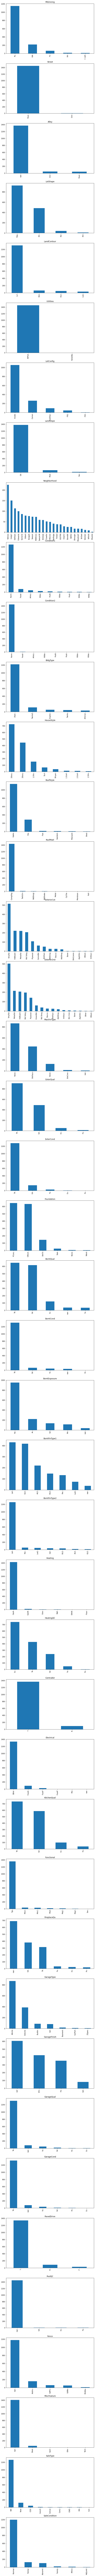

In [5]:
# define a function that will help you plot the variables in order to see the balance (or imbalance) of the variables
categorical = train.iloc[:,[i for i in range(train.shape[1]) if train.iloc[:,i].dtypes == "object"]]  
numerical = train.iloc[:,[i for i in range(train.shape[1]) if train.iloc[:,i].dtypes != "object"]]

fig1, axes1 = plt.subplots(nrows=43,ncols=1,figsize=(10,300))
for i,ax1 in zip(range(categorical.shape[1]),itertools.cycle(axes1.flatten())):
    categorical.iloc[:,i].value_counts(dropna=False).plot(kind="bar",ax=ax1)
    ax1.set_title(categorical.columns[i])


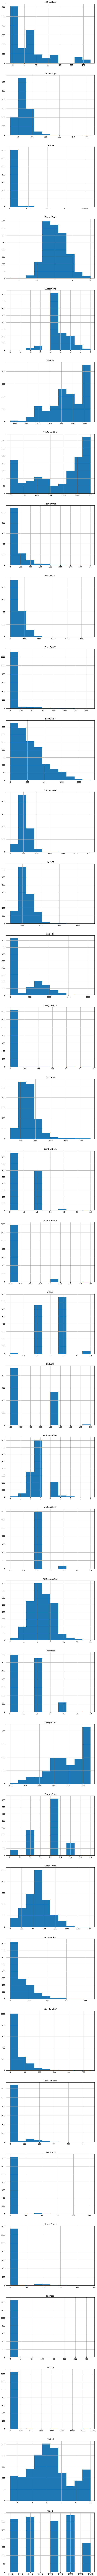

In [6]:
fig1, axes1 = plt.subplots(nrows=36,ncols=1,figsize=(10,300))
for i,ax1 in zip(range(numerical.shape[1]),itertools.cycle(axes1.flatten())):
    numerical.iloc[:,i].hist(ax=ax1, bins=10)
    ax1.set_title(numerical.columns[i])


In [7]:
# important numerical variables
variables_1 = ['YrSold', 'YearRemodAdd', 'MSSubClass', 'YearBuilt', 'GarageArea',  'TotRmsAbvGrd' , 'BsmtUnfSF']
# profound difference
variables_2 = ['MoSold' , 'GrLiveArea', 'OverallCond', 'OverallQual']
# xmmmm
variables_3 = [ 'LotFrontage', 'WoodDeckSF', 'TotalBsmtSF' ,'1stFlrSF','2ndFlrSF', 'GarageCars', 'Fireplaces ', 'BedroomAbvGr']
# almost same 
variables_4 = ['MasVnrArea','OpenPorchSF', 'BsmtFinSF1' , 'HalfBath', 'FullBath','GarageYrBlt', 'BsmtFullBath' ]
# all same
variables_5 = ['LotArea', 'BsmtFinSF2' , 'MiscVal' ,'LowQualFinSF', 'KitchenAbvGr', 'PoolArea', 'ScreenPorch' , '3SsnPorch', 'EnclosedPorch', 'BsmtHalfBath']

ascending_importance = [variables_5,variables_4,variables_3,variables_2,variables_1]


In [ ]:
# percentage of the Nan values of categorical variables per column
pd.DataFrame(categorical.isna().sum().sort_values(ascending=False)/len(categorical)).head()
# the columns with the most Nan values are shown 
# for the categorical variables the Nan values are important, we cannot just drop them 

In [ ]:
# percentage of the Nan values of numerical variables per column
pd.DataFrame(numerical.isna().sum().sort_values(ascending=False)/len(numerical)).head()

## Split the data

In [10]:
# define a function that will split the data as we want -> pass a seed in order to have reproducible results 
from sklearn.model_selection import train_test_split
def train_dev_test_splitter(X,Y,fraction=0.2,seed=1):
    xx_nontest, xx_test, yy_nontest, yy_test = train_test_split(X,Y, test_size=fraction, random_state=seed)
    return xx_nontest, yy_nontest, xx_test, yy_test

x_train, y_train, x_val, y_val = train_dev_test_splitter(train, y_data, fraction=0.15,seed=2)

In [11]:
# the given train set is split to train and validation set -> 
# train set will be used to train the classifiers and validation set will be used to tune them 
categorical_train = x_train.iloc[:,[i for i in range(x_train.shape[1]) if x_train.iloc[:,i].dtypes == "object"]]  
numerical_train = x_train.iloc[:,[i for i in range(x_train.shape[1]) if x_train.iloc[:,i].dtypes != "object"]]
categorical_val = x_val.iloc[:,[i for i in range(x_val.shape[1]) if x_val.iloc[:,i].dtypes == "object"]]  
numerical_val = x_val.iloc[:,[i for i in range(x_val.shape[1]) if x_val.iloc[:,i].dtypes != "object"]]

## Feature selection - may be useful

In [12]:
# calculate the correlation of the numerical variables will respect to y (SalesPrice)
numerical_columns = numerical_train.columns.tolist()
correlation = [(pd.concat([numerical_train[i],y_data],axis=1).corr()).values[0,1] for i in numerical_columns]
feature_selection_df = pd.DataFrame({"columns":numerical_train.columns,"Correlation":np.abs(correlation)})
threshold = 0.3 # correlation threshold -> if the correlation is calculated below that value then the variable will be considered unimportant 
feature_selection_df["Correlation"] = feature_selection_df.Correlation.apply(lambda x: True if x >= threshold else False) # maybe negative correlation


In [13]:
# apply chi-square test - keep the K-Best variables 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
s = pd.DataFrame(numerical_train)
s = s.fillna(numerical_train.mean()) # fill the Nan values with the mean value of the respective column
chi_selector = SelectKBest(chi2, k=30) # keep the top 30 variables
chi_selector.fit(s, y_train)
chi_support = pd.DataFrame({"Chi":chi_selector.get_support()})
feature_selection_df = pd.concat([feature_selection_df,chi_support],axis=1)


In [14]:
# more feature selection test according to the https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2
from sklearn.linear_model import  LinearRegression
from sklearn.feature_selection import RFE
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=None )
rfe_selector.fit(s, y_train)
rfe_support = pd.DataFrame({"RFE":rfe_selector.get_support()})
feature_selection_df = pd.concat([feature_selection_df,rfe_support],axis=1)


In [15]:
# Also, feature selection for the categorical variables
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False,handle_unknown="ignore")
categorical_onehot = enc.fit_transform(categorical_train)
rfe_selector.fit(categorical_onehot, y_train)
feature_selection_categ = pd.DataFrame({"RFE":rfe_selector.get_support()})

In [16]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

embeded_lr_selector = SelectFromModel(Lasso(), threshold="mean")
embeded_lr_selector.fit(s, y_train)
embeded_lr_support = pd.DataFrame({"Lasso":embeded_lr_selector.get_support()})
feature_selection_df = pd.concat([feature_selection_df,embeded_lr_support],axis=1)

embeded_lr_selector = SelectFromModel(Lasso(max_iter=10000), threshold="mean")
embeded_lr_selector.fit(categorical_onehot, y_train)
embeded_lr_support = pd.DataFrame({"Lasso":embeded_lr_selector.get_support()})
feature_selection_categ = pd.concat([feature_selection_categ,embeded_lr_support],axis=1)

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
names = ["RF","LGBM"]
for i,j in zip([RandomForestClassifier(n_estimators=100),LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)],names):
    embeded_rf_selector = SelectFromModel(i,  threshold="mean")
    embeded_rf_selector.fit(s, y_train)

    embeded_rf_support = pd.DataFrame({j:embeded_rf_selector.get_support()})
    feature_selection_df = pd.concat([feature_selection_df,embeded_rf_support],axis=1)

for i,j in zip([RandomForestClassifier(n_estimators=100),LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)],names):
  embeded_rf_selector = SelectFromModel(i,  threshold="mean")
  embeded_rf_selector.fit(categorical_onehot, y_train)

  embeded_rf_support = pd.DataFrame({j :embeded_rf_selector.get_support()})
  feature_selection_categ = pd.concat([feature_selection_categ,embeded_rf_support],axis=1)


In [17]:
feature_selection_df["Total"] = np.sum(feature_selection_df.iloc[:,1:7],axis=1)
features_numerical = feature_selection_df[feature_selection_df.Total.apply(lambda x: x>2)].iloc[:,0]

In [18]:
feature_selection_categ["Total"] = np.sum(feature_selection_categ.iloc[:,0:4],axis = 1)
features_cate = feature_selection_categ[feature_selection_categ.Total.apply(lambda x: x>=0)].index
# features_cate = feature_selection_categ.index

In [19]:
features = list(features_numerical) + list(features_cate)

## Preprocess Data

In [20]:
# preprocess the numerical data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normed_train = scaler.fit_transform(numerical_train)
normed_val = scaler.transform(numerical_val)

# for the numerical data , replace the Nan values with something else 
def del_with_nan(data, mean = np.nan):
  if np.isnan(mean):
    mean = np.nanmean(data) # instead of mean , 0 (zero) is another possible value, or the mode of each column
  else:
    pass
  for i in range(len(data)):
      if np.isnan(data[i]):
        data[i] = mean
  return data, mean

# pre-process the train data 
train_means = [] # keep the mean values of the train because these values should be used for pre-processing the validation and the test set
final_xtrain = []
for i in normed_train.transpose():
    column, mean = del_with_nan(i)
    final_xtrain.append(column)
    train_means.append(mean)

final_xtrain = np.array(final_xtrain).transpose()
final_xtrain = pd.DataFrame(final_xtrain, columns=numerical_train.columns)

# pre-process the validation data 
final_xtest = []
test_means = []
for i in range(normed_val.transpose().shape[0]):
    column, mean = del_with_nan(normed_val.transpose()[i], train_means[i])
    final_xtest.append(column)
    test_means.append(mean)

final_xtest = np.array(final_xtest).transpose()
final_xval = pd.DataFrame(final_xtest, columns=numerical_train.columns)


In [21]:
# preprocess the categorical data
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False,handle_unknown="ignore")
categorical_onehot = enc.fit_transform(categorical_train)
categorical_onehot_val = enc.transform(categorical_val)

In [22]:
# set the data back together 
x_train = pd.concat([final_xtrain,pd.DataFrame(categorical_onehot)],axis=1)
x_train = x_train[features]
x_val =  pd.concat([final_xval,pd.DataFrame(categorical_onehot_val)],axis=1)
x_val = x_val[features]

In [23]:
x_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,ScreenPorch,MoSold,YrSold,0,1,2,3,4,5,6,7,8,9,...,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265
0,-0.878011,-2.015944e-01,-0.271665,-0.788395,1.277645,-0.126597,0.939567,-0.069915,0.017084,-0.331981,-0.419910,-0.668291,-0.799822,-1.165880,-0.808913,-0.243026,-1.016665,-0.756446,0.163459,-0.199737,-0.916092,-0.942666,-0.461373,-1.008558,-0.854504,-0.238233,-0.697479,-0.268948,-0.135392,0.912147,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.470543,1.635431e-16,-0.619945,-0.059335,-0.526174,1.093843,0.939567,0.251593,0.556799,-0.939095,-0.456645,-0.801125,-0.799822,-1.263166,1.117883,-0.243026,-1.016665,-0.756446,-2.295367,-0.199737,-2.139192,0.600670,1.046616,0.330073,-0.234606,0.437613,-0.697479,-0.268948,-0.503053,0.153959,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.061411,6.487667e-01,0.065364,1.398784,-0.526174,1.159812,1.036379,3.804804,-0.966201,1.216968,0.087492,-0.092678,1.150145,0.877132,-0.808913,-0.243026,0.809212,1.245152,0.163459,-0.199737,0.918556,0.600670,1.128129,1.668705,1.329229,0.660245,0.384485,-0.268948,1.335253,-1.362417,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.173445,-4.040613e-01,-0.011538,-0.059335,1.277645,-2.138673,0.503913,-0.563262,-0.966201,0.457499,-0.667871,-1.040746,0.835856,-0.078563,-0.808913,-0.243026,-1.016665,-0.756446,0.163459,-0.199737,0.307007,-0.942666,-2.947518,-1.008558,-1.192631,-0.293891,-0.697479,-0.268948,-0.135392,0.153959,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.061411,1.635431e-16,-0.238530,-0.059335,-0.526174,0.961903,0.745943,-0.563262,-0.966201,0.912257,-0.215572,-0.527643,0.831268,0.293415,-0.808913,-0.243026,0.809212,1.245152,0.163459,-0.199737,0.307007,0.600670,0.883590,0.330073,-0.046758,0.048008,-0.112633,-0.268948,-1.973698,-1.362417,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
x_val.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,ScreenPorch,MoSold,YrSold,0,1,2,3,4,5,6,7,8,9,...,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265
0,-0.878011,1.215674,0.533694,0.669724,2.179554,-0.390476,0.600725,-0.563262,1.758592,-0.701328,1.042600,1.681044,-0.799822,0.554752,1.117883,-0.243026,0.809212,-0.756446,-2.295367,-0.199737,-0.304543,2.144007,-0.787425,0.330073,0.065951,-0.747105,0.092063,2.535503,-1.238375,1.670335,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.061411,0.284326,-0.126531,-0.059335,-0.526174,0.467130,0.019854,1.299263,-0.966201,0.422872,-0.702310,-0.465133,0.932208,0.423130,-0.808913,-0.243026,0.809212,1.245152,0.163459,-0.199737,0.307007,0.600670,0.272243,0.330073,0.028382,0.779511,-0.024907,-0.268948,-0.135392,1.670335,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.296266,0.324820,0.179221,1.398784,0.375735,-1.215097,0.649131,-0.563262,-0.030987,-0.048045,-0.188020,2.043081,2.076953,3.212004,-0.808913,-0.243026,0.809212,1.245152,1.392873,-0.199737,2.141655,2.144007,-1.806336,0.330073,-0.422454,-0.747105,-0.697479,-0.268948,0.967592,-0.604229,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.470543,-1.335409,-0.734524,1.398784,-0.526174,1.126827,0.987973,-0.563262,1.304096,-0.807515,0.459433,0.238104,-0.799822,-0.502044,1.117883,-0.243026,-1.016665,1.245152,-2.295367,-0.199737,-1.527642,0.600670,1.087373,0.330073,0.375900,-0.747105,0.530697,-0.268948,-0.870714,-1.362417,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.470543,-1.051955,-0.419173,0.669724,-0.526174,1.258767,1.230002,0.146271,0.635462,0.155096,0.714281,0.527213,-0.799822,-0.290303,1.117883,-0.243026,0.809212,-0.756446,-1.065954,-0.199737,-0.304543,0.600670,1.291155,0.330073,0.065951,0.779511,-0.185739,-0.268948,-0.135392,1.670335,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Building the Classifiers to be tested

In [25]:
# define the metric of the problem
# re-arrange miscalculations - since log-function is used no negative values should belong to predictions 
from sklearn.metrics import mean_squared_log_error
def score(true, pred):
  for i in range(len(pred)):
    if pred[i] < 0 :
      pred[i] = 0.
  return np.sqrt(mean_squared_log_error(true,pred))


In [26]:
from sklearn.linear_model import Lasso, LinearRegression,SGDRegressor
from sklearn.svm import LinearSVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor

classifier_names = ['Lasso', 'LinearRegression','SGDRegressor' ,'LinearSVR' , 'NuSVR', 'ExtraTreeRegressor', 
                    'DecisionTreeRegressor', 'KNeighborsRegressor', 'RadiusNeighborsRegressor', 
                    'ExtraTreesRegressor', 'GradientBoostingRegressor', 'RandomForestRegressor', 'AdaBoostRegressor']

# run for the same seed in order to have reprodusible outputs 
seed = 1
classifiers = [Lasso(random_state=seed),
               LinearRegression(),
               SGDRegressor(random_state=seed),
               LinearSVR(random_state=seed),
               NuSVR(), 
               ExtraTreeRegressor(random_state=seed),
               DecisionTreeRegressor(random_state=seed),
               KNeighborsRegressor(),
               RadiusNeighborsRegressor(),
               ExtraTreesRegressor(random_state=seed),
               GradientBoostingRegressor(random_state=seed),
               RandomForestRegressor(random_state=seed),
               AdaBoostRegressor(random_state=seed)]

In [ ]:
# iterate over all the classifiers
scores = []
for classifier_name, classifier in zip(classifier_names, classifiers):
  classifier.fit(x_train, y_train)
  predictions = classifier.predict(x_val)
  scoring = score(y_val, predictions)
  scores.append(scoring)
  print(classifier_name ," \t",  scoring)
# another approach is that the above cell will run many times for different seeds and take the mean value of their scores 
# so that the initial positions of the classifiers will not affect their score too much

In [ ]:
print("The minimum score is " , min(scores), " of the classifier " ,classifier_names[np.argmin(scores)]) 

## Hyper-parameter tuning of the highest scoring classifier(s)

In [31]:
# build a pipeline with the highest scoring classifiers -> there are more than 1 since their score was quite close with each other 
classifiers = {"NuSVR":NuSVR(),               
               "GradientBoostingRegressor":GradientBoostingRegressor(random_state=seed),
               "RandomForestRegressor":RandomForestRegressor(random_state=seed)}

# make a dictionary with all the parameters to be checked for these classifiers
parameters = {"NuSVR":{"nu": [0.1, 0.5, 0.9],
                       "C": [0.1, 0.5, 1.],
                       "kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
                       "tol": [1e-3, 1e-4],
                       "gamma": ['scale', 'auto']},
              "GradientBoostingRegressor":{"max_depth" : [None, 3, 5, 10],
                                           "min_samples_leaf" : [1,2,5],
                                           "min_weight_fraction_leaf" : [0. , 0.2],
                                           "max_leaf_nodes" : [None , 2],
                                           "n_estimators" : [50 , 100, 200],
                                           "min_samples_split" : [2, 5 , 10],
                                           "learning_rate" : [0.1, 0.01]},
              "RandomForestRegressor":{"max_depth" : [None, 3, 5, 10],
                                       "min_samples_leaf" : [1,2,5],
                                       "min_weight_fraction_leaf" : [0. , 0.2],
                                       "max_leaf_nodes" : [None , 2],
                                       "n_estimators" : [50 , 100, 200],
                                       "min_samples_split" : [2, 5 , 10]}
              }

In [32]:
from sklearn.model_selection import GridSearchCV 
# for a more complicated problem a random search algorithm could be used -> no need for that at this problem
from sklearn.metrics import make_scorer
custom_scorer = make_scorer(score,greater_is_better=False)

def fit(train_features, train_actuals):
        """
        fits the list of models to the training data, thereby obtaining in each 
        case an evaluation score after GridSearchCV cross-validation
        """
        for name in classifiers.keys():
            est = classifiers[name]
            est_params = parameters[name]
            gscv = GridSearchCV(estimator=est,param_grid=est_params, cv=3, scoring=custom_scorer) 
            gscv.fit(train_features, train_actuals)
            print("best parameters are: {}, with best score : {}".format(gscv.best_estimator_,gscv.best_score_))

In [ ]:
fit(x_train, y_train)

In [ ]:
est = NuSVR(kernel='linear').fit(x_train, y_train)
print("NuSVR {:.5f}".format(score(y_val,est.predict(x_val))))
est = GradientBoostingRegressor(min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=1).fit(x_train, y_train)
print("Gradient Boosting {:.5f}".format( score(y_val,est.predict(x_val))))
est = RandomForestRegressor(n_estimators=200, random_state=1).fit(x_train, y_train)
print("Random Forest {:.5f}".format( score(y_val,est.predict(x_val))))

## Train the final classifier over the whole dataset (cross-validation)

In [34]:
# prepare the whole dataset for training the classifier
categorical_final_train = train.iloc[:,[i for i in range(train.shape[1]) if train.iloc[:,i].dtypes == "object"]]  
numerical_final_train = train.iloc[:,[i for i in range(train.shape[1]) if train.iloc[:,i].dtypes != "object"]]
normed_final_train = scaler.fit_transform(numerical_final_train)
train_means = []
FINAL_xtrain = []
for i in normed_final_train.transpose():
    column, mean = del_with_nan(i)
    FINAL_xtrain.append(column)
    train_means.append(mean)

FINAL_xtrain = np.array(FINAL_xtrain).transpose()
FINAL_xtrain = pd.DataFrame(FINAL_xtrain, columns=numerical_final_train.columns)

FINAL_categorical_onehot = enc.fit_transform(categorical_final_train)

FINAL_x_train = pd.concat([FINAL_xtrain,pd.DataFrame(FINAL_categorical_onehot)],axis=1)
FINAL_x_train = FINAL_x_train[features]

In [ ]:
final_classifier = GradientBoostingRegressor(min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=1)
final_classifier.fit(FINAL_x_train, y_data)
train_predictions = final_classifier.predict(FINAL_x_train)
score(y_data, train_predictions)

## Get ready the test data and make the predictions

In [36]:
# just have ready the classifier (trained, tuned, etc) and named 'final_classifier'
# pre-process the test data the same way with the train data
test = pd.read_csv("test.csv")
test_id = test.pop('Id')

categorical_test = test.iloc[:,[i for i in range(test.shape[1]) if test.iloc[:,i].dtypes == "object"]]
numerical_test = test.iloc[:,[i for i in range(test.shape[1]) if test.iloc[:,i].dtypes != "object"]]
assert categorical_test.shape[1] + numerical_test.shape[1] == test.shape[1], "dimensions mismatch"

normed_test = scaler.transform(numerical_test)
final_xtest = []
test_means = []
for i in range(normed_test.transpose().shape[0]):
    column, mean = del_with_nan(normed_test.transpose()[i], train_means[i])
    final_xtest.append(column)
    test_means.append(mean)

final_xtest = np.array(final_xtest).transpose()
final_xtest = pd.DataFrame(final_xtest, columns=numerical_train.columns)

one_hot = enc.transform(categorical_test)

x_test = pd.concat([final_xtest,pd.DataFrame(one_hot)],axis=1)
x_test = x_test[features]


In [37]:
predictions = final_classifier.predict(x_test)

## Submit predictions 

In [38]:
# make the .csv file and submit the predictions
submit = pd.DataFrame()
submit['Id'] = test_id
submit['SalePrice'] = predictions
submit.to_csv('submission.csv', index=False)
! kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Message"


100% 33.7k/33.7k [00:02<00:00, 13.2kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

## MLP approach -> gave a little better score

In [39]:
# import the basic tensorflow libraries
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.initializers import glorot_uniform

# define a function for plotting the scors of each MLP
def plot(history):
    plt.plot(history.history['loss'][50:]) # the first 50 epochs have very high MSE -> for better calibration they are omitted
    plt.plot(history.history['val_loss'][50:])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper right')
    plt.show()
    return


In [40]:
# hyperparameters
learning_rate = [0.001, 0.01, 0.1] # learning rate and activation function are the most important ones! 
activation_function = ['relu', 'tanh', 'selu']
dropout_rate = [0.1, 0.2]
num_neurons = [100, 200, 300]
num_layers = [2,4,6]
dense_initializer = glorot_uniform(seed=1) # in order to have as reproducible outcomes as possible (utilizing GPU will make non-reproducible the results due to the parallelization of calculations)


In [ ]:
# grid search over all the combinations of the above hyperparameters
mlp_scores = []
counter = 0
for a in num_layers:
  for b in num_neurons:
    for c in dropout_rate:
      for d in activation_function:
        for e in learning_rate:
          
          counter += 1
          model = Sequential()
          model.add(Dense(b, activation = d, input_dim = x_train.shape[1], kernel_initializer=dense_initializer)) # input_dim may vary according to the feature extraction applied
          model.add(Dropout(c, seed = 1))
          if a > 2 :            
            model.add(Dense(units = b, activation = d, kernel_initializer=dense_initializer))
            model.add(Dense(units = b, activation = d, kernel_initializer=dense_initializer))
            model.add(Dropout(c, seed = 1))
          if a > 4 :            
            model.add(Dense(units = b, activation = d, kernel_initializer=dense_initializer))
            model.add(Dense(units = b, activation = d, kernel_initializer=dense_initializer))
            model.add(Dropout(c, seed = 1))
          model.add(Dense(units = 1))
          model.compile(optimizer = Adam(learning_rate=e),loss = 'mean_squared_logarithmic_error')
          print(model.summary())
          checkpoint = EarlyStopping(monitor='val_loss', verbose=1, patience=20, mode='min', restore_best_weights=True) 
          history = model.fit(x_train, y_train, batch_size = 128, epochs = 300, validation_split=0.15, verbose=0)

          predictions = model.predict(x_val)
          scoring = score(y_val,predictions)
          mlp_scores.append(scoring)
          plot(history)
          print(counter)
          print(scoring)
          print()
          

In [ ]:
# the highest scoring hyperparameters
num_layers = [6] 
num_neurons = [100] 
dropout_rate = [0.1] 
activation_function = ['relu']
learning_rate = [0.001]
counter = 0

for a in num_layers:
  for b in num_neurons:
    for c in dropout_rate:
      for d in activation_function:
        for e in learning_rate:
          
          counter += 1
          final_classifier = Sequential()
          final_classifier.add(Dense(b, activation = d, input_dim = x_train.shape[1], kernel_initializer=dense_initializer))
          final_classifier.add(Dropout(c, seed = 1))
          if a > 2 :            
            final_classifier.add(Dense(units = b, activation = d, kernel_initializer=dense_initializer))
            final_classifier.add(Dense(units = b, activation = d, kernel_initializer=dense_initializer))
            final_classifier.add(Dropout(c, seed = 1))
          if a > 4 :            
            final_classifier.add(Dense(units = b, activation = d, kernel_initializer=dense_initializer))
            final_classifier.add(Dense(units = b, activation = d, kernel_initializer=dense_initializer))
            final_classifier.add(Dropout(c, seed = 1))
          final_classifier.add(Dense(units = 1))
          final_classifier.compile(optimizer = Adam(learning_rate=e),loss = 'mean_squared_logarithmic_error')
          print(final_classifier.summary())
          checkpoint = EarlyStopping(monitor='val_loss', verbose=1, patience=50, mode='min', restore_best_weights=True)
          history = final_classifier.fit(x_train, y_train, batch_size = 128, epochs = 350, validation_data=(x_val,y_val), verbose=0, callbacks=checkpoint)

          predictions = final_classifier.predict(x_val)
          scoring = score(y_val,predictions)
          plot(history)
          print(counter)
          print(scoring)


In [45]:
predictions = final_classifier.predict(x_test)
submit = pd.DataFrame()
submit['Id'] = test_id
submit['SalePrice'] = predictions
submit.to_csv('submission.csv', index=False)
! kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Message"


100% 21.1k/21.1k [00:03<00:00, 7.17kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

## Final Comments : The **best** score achieved was **0.12534** giving us the ranking of **top 18%** for this competition (more than **5000 teams** participating the time we submitted our predictions)

However there are still more ways that can possibly make this score even better. We did not checked thouroughly the methods below because we had set as a team a **4-days plan** to tackle this competition. Our suggestions for further improvement are:

*   Handle differently the Nan values of the set. For example, regarding the numerical values, instead using the mean of the respective column for replacing the Nans, someone can use 0 or the mode of the column.
*   Handle some numerical values as categorical, for example the Year that the house was Sold. 
*   Apply more (or less, *or None*) feature extraction tests.
*   Use XGBoost Regressor
*   Make more extensive grid search over the MLP parameters. For example, someone can check the case were each layer has different activation funstion from the other or different number of neurons. 

